# Executive Summary

I'm using the environment in the OpenAI gym - Classic Control to practice how to train an agent by reinforcement learning. In this notebook, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track and ***the goal is to prevent it from falling over.***

I try differnet methods to complete this goal:

***1. Create a simple policy (without any learning applied)*** (See Section 4)
- Result: by using a simple policy ***the score in between 134 to 235 (average 181) prevent it from falling over*** 
- I tried choosing action by monitoring all four observations (Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity) in the simple policy, ***choosing action by monitoring the Pole Angular Velocity has the best score***.

***2. Create a Deep Learning Neural Network with Keras*** (See Section 5)
- Result: the agent received ***all perfect scores to prevent the Pole from falling over*** 
- the log on the above showing that we may ***reduce number of learning timesteps to 40000***, because the agent start received 500 episode reward start in the 36220 episode consistently.

***3. Epsilon-Greedy Policy*** (See Section 6-7)
- Result: The learning process with ***Epsilon-Greedy Policy reach perfect score at epoch #31*** (time spend: learning 6min).


### ***Table of Content:***

1. What is CartPole
2. Import Dependencies
3. Understanding The Environment
4. Create a Simple Policy (without any Learning to Comlete the Goal)
5. Create a Deep Learning Neural Network with Keras
   - 5.1 Build Agent with Keras-RL
   - 5.2 Train the Agents
6. Epsilon-Greedy Policy
7. Q-learning via Gradient Descent

# 1. What is CartPole?

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and ***the goal is to prevent it from falling over***. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

### Action Space
- The agent take a 1-element vector for actions.
- The action space is `(action)` in `[0, 1]`, where `action` is used to push the cart with a fixed amount of force:


 Num | Action                 |
-----|------------------------|
 0   | Push cart to the left  |
 1   | Push cart to the right |
 
### Observation Space
The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:

 Num | Observation           | Min                   | Max                 |
-----|-----------------------|-----------------------|---------------------|
 0   | Cart Position         | -4.8*                 | 4.8*                |
 1   | Cart Velocity         | -Inf                  | Inf                 |
 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
 3   | Pole Angular Velocity | -Inf                  | Inf                 |
 
### Rewards
Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.

env = gym.make('CartPole-v1')

states = env.observation_space.shape[0]      # 4 States under CartPole

actions = env.action_space.n                 # 2 Actions: Left, Right

# 2. Import Dependencies

2022-03-19 13:26:45.868 python[1328:41163] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f994fe5d8c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-19 13:26:45.869 python[1328:41163] Warning: Expected min height of view: (<NSButton: 0x7f994fe421e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-19 13:26:45.872 python[1328:41163] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f994fe45100>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-19 13:26:45.874 python[1328:41163] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f994fe4adc0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


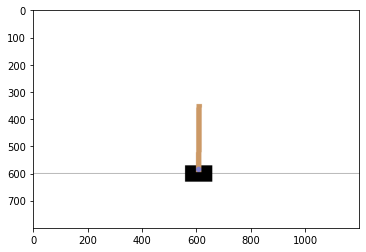

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")                          # Using CartPole verion 1 in this notebook
env.reset()                                            # reset the environment to initial default

plt.imshow(env.render('rgb_array'))                    # display the environment
print("Observation space:", env.observation_space)     # ndarray with shape (4,)
print("Action space:", env.action_space)               # 2 actions could be taken in this environment: Push cart to the left, Push cart to the right

In [3]:
env.close

<bound method Wrapper.close of <TimeLimit<CartPoleEnv<CartPole-v1>>>>

# 3. Understanding The Environment

In [5]:
obs = env.reset()
print("initial observation code:", obs)

# Note: in CartPole, observation is just 4 numbers: Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity	

initial observation code: [-0.01050036  0.03147893  0.03254453 -0.0046213 ]


In [7]:
# If an action 2: acelerate to right is given into the environment
new_obs, reward, is_done, _ = env.step(1)

print("taking action 2 (right)")

# Then the environment will reply 3 things new_observation, reward and is_done to the agent
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

# Note: the car has moved to the right slightly (from -0.4775 to -0.4769 around 0.001 moved to right)

taking action 2 (right)
new observation code: [-0.00987078  0.2261194   0.0324521  -0.286861  ]
reward: 1.0
is game over?: False


### Project Baseline Use Random Action

In [8]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = env.action_space.sample()                 # random choose an action 
        
        n_obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation (4 observation in this case)
                                                            # 2. reward is 1 for every step taken
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:27.0 Timesteps Spend:27
Episode:2 Score:41.0 Timesteps Spend:41
Episode:3 Score:10.0 Timesteps Spend:10
Episode:4 Score:17.0 Timesteps Spend:17
Episode:5 Score:20.0 Timesteps Spend:20
CPU times: user 52.5 ms, sys: 17.5 ms, total: 70.1 ms
Wall time: 89.8 ms


Remark: 
- The above 5 episode showing that, ***the score in between 10 to 41 (average 23) prevent it from falling over*** 

# 4. Create a Simple Policy (without any Learning to Comlete the Goal)

So, now let's create a simply policy (without any learning) to prevent it from falling over.

Note: in CartPole, observation is just 4 numbers: Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity	

In [33]:
# Define 3 actions as Dictionary
actions = {'Push cart to the left': 0, 'Push cart to the right': 1}      

# Define a policy
def simple_policy(obs):
    
    position, cart_velocity, angle, pole_velocity = obs        # observe current postion and velocity

    if pole_velocity < 0:                                      # if current velocity is positive
        return actions['Push cart to the left']                # the policy return an actions 'Push cart to the left' 

    if pole_velocity > 0:                                      # if current velocity is negative
        return actions['Push cart to the right']               # the policy choose an actions 'Push cart to the right'

### Evaluate the Simple Policy

In [35]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = simple_policy(obs)                        # random choose an action 
        
        obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation (4 observation in this case)
                                                            # 2. reward (Positive value increment, negative value decrement)
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:185.0 Timesteps Spend:185
Episode:2 Score:235.0 Timesteps Spend:235
Episode:3 Score:193.0 Timesteps Spend:193
Episode:4 Score:134.0 Timesteps Spend:134
Episode:5 Score:159.0 Timesteps Spend:159
CPU times: user 305 ms, sys: 90.7 ms, total: 395 ms
Wall time: 469 ms


Remark: 
- The above 5 episode showing that, by using a simple policy ***the score in between 134 to 235 (average 181) prevent it from falling over*** 
- I tried choosing action by monitoring all four observations (Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity) in the simple policy, ***choosing action by monitoring the Pole Angular Velocity has the best score***.

# 5. Create a Deep Learning Neural Network with Keras

In [39]:
# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Build a Sequential Model
def build_network(states, actions):
    
    network = Sequential()
    
    network.add(Flatten(input_shape = (1, states), name = 'States'))      # use Flatten layer as the input layer, input_shape = 1 x number of state 
    
    network.add(Dense(512, activation = 'relu', name = 'Dense_1'))        # use Dense layer with 512 units of tensor with relu activation function
    
    network.add(Dense(256, activation = 'relu', name = 'Dense_2'))        # use another Dense layer with 256 units of tensor with relu activation function
    
    network.add(Dense(actions, activation = 'linear', name = 'Actions'))  # the output layer with shape = number of actions with linear activation function
                                                                           # Output the probability for each actions 
    
    return network                                                        # build_model return a model

In [46]:
del network

In [47]:
# Set the input_shape of the build_model function
states = env.observation_space.shape[0]                         # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
actions = env.action_space.n                                    # use .n to return number of action

# Run the build_model function to build the model
network = build_network(states, actions)                            

# See the model summary
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 4)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               2560      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
Actions (Dense)              (None, 2)                 514       
Total params: 134,402
Trainable params: 134,402
Non-trainable params: 0
_________________________________________________________________


# 5.1 Build Agent with Keras-RL

In [48]:
# Import Dependencies
from rl.agents import DQNAgent                                                      # used DQNAgent here, should try other agents: SARSAAgent      
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy      # used Policy base RL  
from rl.memory import SequentialMemory
import os

# Build an Agent to learn from the model
def build_agent(model, actions):            
    
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),    # use EpsGreedyQPolicy()
                                  attr='eps',
                                  value_max = 1,
                                  value_min = .1,
                                  value_test = 0.2,
                                  nb_steps = 10000
    )                    

    memory = SequentialMemory(limit = 1000,              # buffer limit: number of episode
                              window_length = 1          # store pass 1 window for 1000 episode 
                             )
    
    dqn = DQNAgent(model = model, 
                   memory = memory,
                   policy = policy,
                   enable_dueling_network = True,        # Dueling Networks split value and advantage, help the model learn when to take action and when not to bother
                   dueling_type = 'avg',
                   nb_actions = actions,                 # 3 actions to learn
                   nb_steps_warmup = 1000,           
                   target_model_update = 1e-2
                  )
    
    return dqn

# 5.2 Train the Agent

In [49]:
# set the path to save the log
log_path = os.path.join("Training", "Logs", "CartPole-v1_Keras-RL")

In [52]:
%%time
# run the build_agent function to traing the agent
agent = build_agent(network, actions)                      # used build_agent to setup a dqn model

agent.compile(Adam(learning_rate = 1e-4),                # use Adam optimisation with learning rate 0.0001
            metrics = ['mae']                            # use mean absolute error to evaluate the metric
           )      

history = agent.fit(env, 
        nb_steps = 500000,                               # number of timesteps 
        visualize = False,                               # visualize during the training
        verbose = 2                                      # how to show the training output
       )

Training for 500000 steps ...
     15/500000: episode: 1, duration: 0.070s, episode steps:  15, steps per second: 215, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     45/500000: episode: 2, duration: 0.014s, episode steps:  30, steps per second: 2086, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     78/500000: episode: 3, duration: 0.015s, episode steps:  33, steps per second: 2226, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     90/500000: episode: 4, duration: 0.006s, episode steps:  12, steps per second: 2087, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.833 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    105/500000: episode: 5, duration: 0.007

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    304/500000: episode: 14, duration: 0.009s, episode steps:  19, steps per second: 2036, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    321/500000: episode: 15, duration: 0.009s, episode steps:  17, steps per second: 1903, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    332/500000: episode: 16, duration: 0.006s, episode steps:  11, steps per second: 1851, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    357/500000: episode: 17, duration: 0.011s, episode steps:  25, steps per second: 2207, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    373/500000: episode: 18, duration: 0.008s, episode steps:  16, s

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1017/500000: episode: 49, duration: 0.522s, episode steps:  26, steps per second:  50, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 16.887636, mae: 4.696716, mean_q: 8.960082, mean_eps: 0.909235
   1032/500000: episode: 50, duration: 0.076s, episode steps:  15, steps per second: 197, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 8.867466, mae: 4.665575, mean_q: 9.450425, mean_eps: 0.907840
   1046/500000: episode: 51, duration: 0.066s, episode steps:  14, steps per second: 211, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 5.168766, mae: 5.049514, mean_q: 9.781283, mean_eps: 0.906535
   1061/500000: episode: 52, duration: 0.074s, episode steps:  15, steps per second: 203, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 2.697559, mae: 5.071849, mean_q: 9.96

   2095/500000: episode: 83, duration: 0.167s, episode steps:  35, steps per second: 210, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 0.823913, mae: 8.260288, mean_q: 16.602191, mean_eps: 0.813070
   2139/500000: episode: 84, duration: 0.209s, episode steps:  44, steps per second: 211, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 1.011767, mae: 8.403628, mean_q: 16.922491, mean_eps: 0.809515
   2194/500000: episode: 85, duration: 0.259s, episode steps:  55, steps per second: 212, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 1.035371, mae: 8.638543, mean_q: 17.356946, mean_eps: 0.805060
   2228/500000: episode: 86, duration: 0.159s, episode steps:  34, steps per second: 214, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.441 [0.000, 1.000],  loss: 0.924543, mae: 8.774709, mean_q: 17

   3576/500000: episode: 116, duration: 0.102s, episode steps:  21, steps per second: 205, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 1.836663, mae: 14.576106, mean_q: 29.770343, mean_eps: 0.679150
   3600/500000: episode: 117, duration: 0.117s, episode steps:  24, steps per second: 204, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 2.582568, mae: 14.727703, mean_q: 30.112892, mean_eps: 0.677125
   3632/500000: episode: 118, duration: 0.153s, episode steps:  32, steps per second: 210, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 2.703619, mae: 14.882109, mean_q: 30.357943, mean_eps: 0.674605
   3661/500000: episode: 119, duration: 0.132s, episode steps:  29, steps per second: 220, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 2.663419, mae: 15.108057, me

   6713/500000: episode: 148, duration: 1.063s, episode steps: 216, steps per second: 203, episode reward: 216.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 1.464353, mae: 25.009956, mean_q: 50.726705, mean_eps: 0.405595
   6836/500000: episode: 149, duration: 0.588s, episode steps: 123, steps per second: 209, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 1.106099, mae: 25.155809, mean_q: 51.020592, mean_eps: 0.390340
   7036/500000: episode: 150, duration: 0.949s, episode steps: 200, steps per second: 211, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 1.226385, mae: 25.107759, mean_q: 50.760701, mean_eps: 0.375805
   7213/500000: episode: 151, duration: 0.808s, episode steps: 177, steps per second: 219, episode reward: 177.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 0.819000, mae: 24.572307

  12907/500000: episode: 180, duration: 1.007s, episode steps: 222, steps per second: 221, episode reward: 222.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 0.011046, mae: 30.440739, mean_q: 61.141921, mean_eps: 0.100000
  13139/500000: episode: 181, duration: 1.175s, episode steps: 232, steps per second: 197, episode reward: 232.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 0.009320, mae: 30.820974, mean_q: 61.874678, mean_eps: 0.100000
  13393/500000: episode: 182, duration: 1.320s, episode steps: 254, steps per second: 192, episode reward: 254.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 0.009719, mae: 30.999265, mean_q: 62.196512, mean_eps: 0.100000
  13628/500000: episode: 183, duration: 1.085s, episode steps: 235, steps per second: 217, episode reward: 235.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.007232, mae: 30.622329

  20861/500000: episode: 212, duration: 0.975s, episode steps: 199, steps per second: 204, episode reward: 199.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.827188, mae: 40.468924, mean_q: 81.056425, mean_eps: 0.100000
  21075/500000: episode: 213, duration: 1.116s, episode steps: 214, steps per second: 192, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 3.173036, mae: 40.337797, mean_q: 80.776400, mean_eps: 0.100000
  21277/500000: episode: 214, duration: 0.978s, episode steps: 202, steps per second: 207, episode reward: 202.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 3.787800, mae: 40.408827, mean_q: 80.757304, mean_eps: 0.100000
  21459/500000: episode: 215, duration: 0.988s, episode steps: 182, steps per second: 184, episode reward: 182.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 2.443058, mae: 40.379050

  29331/500000: episode: 244, duration: 1.577s, episode steps: 354, steps per second: 225, episode reward: 354.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 0.028059, mae: 39.074819, mean_q: 78.298890, mean_eps: 0.100000
  29659/500000: episode: 245, duration: 1.507s, episode steps: 328, steps per second: 218, episode reward: 328.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.042834, mae: 38.549682, mean_q: 77.208909, mean_eps: 0.100000
  29993/500000: episode: 246, duration: 1.627s, episode steps: 334, steps per second: 205, episode reward: 334.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.025065, mae: 39.117879, mean_q: 78.353836, mean_eps: 0.100000
  30334/500000: episode: 247, duration: 1.683s, episode steps: 341, steps per second: 203, episode reward: 341.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 0.021773, mae: 38.599070

  41837/500000: episode: 276, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.027660, mae: 42.644245, mean_q: 85.451531, mean_eps: 0.100000
  42337/500000: episode: 277, duration: 2.273s, episode steps: 500, steps per second: 220, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.497746, mae: 46.663404, mean_q: 93.273722, mean_eps: 0.100000
  42837/500000: episode: 278, duration: 2.323s, episode steps: 500, steps per second: 215, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.426369, mae: 50.356322, mean_q: 100.514013, mean_eps: 0.100000
  43337/500000: episode: 279, duration: 2.326s, episode steps: 500, steps per second: 215, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.681182, mae: 51.1364

  54071/500000: episode: 308, duration: 2.408s, episode steps: 500, steps per second: 208, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.263963, mae: 49.613125, mean_q: 99.391540, mean_eps: 0.100000
  54571/500000: episode: 309, duration: 2.400s, episode steps: 500, steps per second: 208, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.685316, mae: 46.940982, mean_q: 93.961969, mean_eps: 0.100000
  55071/500000: episode: 310, duration: 2.323s, episode steps: 500, steps per second: 215, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.290096, mae: 45.275020, mean_q: 90.542647, mean_eps: 0.100000
  55571/500000: episode: 311, duration: 2.487s, episode steps: 500, steps per second: 201, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.912971, mae: 45.204767

  69372/500000: episode: 340, duration: 1.206s, episode steps: 270, steps per second: 224, episode reward: 270.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 8.391257, mae: 45.915764, mean_q: 91.805935, mean_eps: 0.100000
  69749/500000: episode: 341, duration: 1.782s, episode steps: 377, steps per second: 212, episode reward: 377.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 5.471382, mae: 42.298916, mean_q: 84.736367, mean_eps: 0.100000
  70249/500000: episode: 342, duration: 2.447s, episode steps: 500, steps per second: 204, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.682816, mae: 40.223379, mean_q: 80.915358, mean_eps: 0.100000
  70749/500000: episode: 343, duration: 2.465s, episode steps: 500, steps per second: 203, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.744609, mae: 43.876250

  85249/500000: episode: 372, duration: 2.461s, episode steps: 500, steps per second: 203, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.187153, mae: 48.911267, mean_q: 97.684798, mean_eps: 0.100000
  85749/500000: episode: 373, duration: 2.470s, episode steps: 500, steps per second: 202, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.588918, mae: 44.532834, mean_q: 88.982927, mean_eps: 0.100000
  86249/500000: episode: 374, duration: 2.417s, episode steps: 500, steps per second: 207, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.706586, mae: 43.946036, mean_q: 87.723079, mean_eps: 0.100000
  86749/500000: episode: 375, duration: 2.445s, episode steps: 500, steps per second: 205, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 7.551957, mae: 46.16675

 100586/500000: episode: 407, duration: 0.059s, episode steps:  10, steps per second: 170, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 34.197634, mae: 47.741802, mean_q: 94.697960, mean_eps: 0.100000
 101086/500000: episode: 408, duration: 2.468s, episode steps: 500, steps per second: 203, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.175072, mae: 46.815515, mean_q: 93.384061, mean_eps: 0.100000
 101524/500000: episode: 409, duration: 2.151s, episode steps: 438, steps per second: 204, episode reward: 438.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 8.886299, mae: 46.943006, mean_q: 94.012290, mean_eps: 0.100000
 101789/500000: episode: 410, duration: 1.274s, episode steps: 265, steps per second: 208, episode reward: 265.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.671133, mae: 44.15773

 115983/500000: episode: 439, duration: 1.393s, episode steps: 307, steps per second: 220, episode reward: 307.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 4.239835, mae: 42.439800, mean_q: 84.874608, mean_eps: 0.100000
 116471/500000: episode: 440, duration: 2.388s, episode steps: 488, steps per second: 204, episode reward: 488.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 2.116216, mae: 36.876160, mean_q: 73.982522, mean_eps: 0.100000
 116971/500000: episode: 441, duration: 2.372s, episode steps: 500, steps per second: 211, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.397423, mae: 35.619331, mean_q: 71.474394, mean_eps: 0.100000
 117471/500000: episode: 442, duration: 2.284s, episode steps: 500, steps per second: 219, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.895264, mae: 39.653960

 128645/500000: episode: 471, duration: 1.477s, episode steps: 324, steps per second: 219, episode reward: 324.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 0.461827, mae: 29.876611, mean_q: 60.094851, mean_eps: 0.100000
 128989/500000: episode: 472, duration: 1.571s, episode steps: 344, steps per second: 219, episode reward: 344.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 0.285504, mae: 29.901567, mean_q: 60.180267, mean_eps: 0.100000
 129366/500000: episode: 473, duration: 1.799s, episode steps: 377, steps per second: 210, episode reward: 377.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 0.050552, mae: 33.754607, mean_q: 67.856554, mean_eps: 0.100000
 129734/500000: episode: 474, duration: 1.665s, episode steps: 368, steps per second: 221, episode reward: 368.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 0.028319, mae: 34.749935

 143542/500000: episode: 503, duration: 2.408s, episode steps: 500, steps per second: 208, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.335771, mae: 38.846480, mean_q: 77.578196, mean_eps: 0.100000
 144042/500000: episode: 504, duration: 2.382s, episode steps: 500, steps per second: 210, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 1.165569, mae: 39.767248, mean_q: 79.483754, mean_eps: 0.100000
 144542/500000: episode: 505, duration: 2.364s, episode steps: 500, steps per second: 211, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.205193, mae: 43.141159, mean_q: 86.222088, mean_eps: 0.100000
 145042/500000: episode: 506, duration: 2.521s, episode steps: 500, steps per second: 198, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.340801, mae: 45.398265

 159542/500000: episode: 535, duration: 2.259s, episode steps: 500, steps per second: 221, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.117352, mae: 19.562317, mean_q: 39.314885, mean_eps: 0.100000
 159933/500000: episode: 536, duration: 1.736s, episode steps: 391, steps per second: 225, episode reward: 391.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 0.074067, mae: 19.367812, mean_q: 38.934537, mean_eps: 0.100000
 160261/500000: episode: 537, duration: 1.464s, episode steps: 328, steps per second: 224, episode reward: 328.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.176183, mae: 21.922183, mean_q: 43.972728, mean_eps: 0.100000
 160428/500000: episode: 538, duration: 0.749s, episode steps: 167, steps per second: 223, episode reward: 167.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.230824, mae: 22.900833

 172807/500000: episode: 567, duration: 2.245s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.068269, mae: 52.753228, mean_q: 105.577295, mean_eps: 0.100000
 173307/500000: episode: 568, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.481054, mae: 51.876953, mean_q: 103.756328, mean_eps: 0.100000
 173807/500000: episode: 569, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.398598, mae: 50.967459, mean_q: 101.966300, mean_eps: 0.100000
 174307/500000: episode: 570, duration: 2.218s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 8.963231, mae: 50.0

 188145/500000: episode: 599, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.817883, mae: 45.338183, mean_q: 90.786131, mean_eps: 0.100000
 188645/500000: episode: 600, duration: 2.245s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.928494, mae: 44.939236, mean_q: 89.982289, mean_eps: 0.100000
 189145/500000: episode: 601, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.207838, mae: 48.558087, mean_q: 97.082038, mean_eps: 0.100000
 189645/500000: episode: 602, duration: 2.222s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.971918, mae: 49.446796

 203659/500000: episode: 631, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.996783, mae: 42.050360, mean_q: 84.479577, mean_eps: 0.100000
 204159/500000: episode: 632, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.696278, mae: 47.917503, mean_q: 95.871565, mean_eps: 0.100000
 204659/500000: episode: 633, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.362879, mae: 50.794831, mean_q: 101.562877, mean_eps: 0.100000
 205159/500000: episode: 634, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.151442, mae: 50.970

 219659/500000: episode: 663, duration: 2.269s, episode steps: 500, steps per second: 220, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.855110, mae: 49.444239, mean_q: 98.717996, mean_eps: 0.100000
 220159/500000: episode: 664, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.380193, mae: 49.263625, mean_q: 98.318904, mean_eps: 0.100000
 220659/500000: episode: 665, duration: 2.231s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.638563, mae: 48.894172, mean_q: 97.900781, mean_eps: 0.100000
 221159/500000: episode: 666, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.243375, mae: 46.49953

 235171/500000: episode: 695, duration: 2.227s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.829032, mae: 50.649532, mean_q: 101.159700, mean_eps: 0.100000
 235671/500000: episode: 696, duration: 2.229s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.224789, mae: 51.659830, mean_q: 103.070361, mean_eps: 0.100000
 236171/500000: episode: 697, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.266616, mae: 51.448517, mean_q: 102.817041, mean_eps: 0.100000
 236671/500000: episode: 698, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.733341, mae: 51.

 250731/500000: episode: 727, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 5.507854, mae: 43.599164, mean_q: 87.170171, mean_eps: 0.100000
 251231/500000: episode: 728, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.620464, mae: 47.892787, mean_q: 96.096200, mean_eps: 0.100000
 251731/500000: episode: 729, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.025456, mae: 51.211432, mean_q: 102.551775, mean_eps: 0.100000
 252231/500000: episode: 730, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.741118, mae: 52.1765

 265732/500000: episode: 759, duration: 2.225s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.749319, mae: 49.167233, mean_q: 98.517053, mean_eps: 0.100000
 266232/500000: episode: 760, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.124222, mae: 52.458696, mean_q: 104.748318, mean_eps: 0.100000
 266732/500000: episode: 761, duration: 2.256s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 8.813203, mae: 51.985294, mean_q: 103.899256, mean_eps: 0.100000
 267232/500000: episode: 762, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 9.636675, mae: 51.489

 280645/500000: episode: 791, duration: 2.240s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.506838, mae: 25.329898, mean_q: 50.773510, mean_eps: 0.100000
 281145/500000: episode: 792, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 1.012993, mae: 30.748457, mean_q: 61.683679, mean_eps: 0.100000
 281645/500000: episode: 793, duration: 2.223s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.083645, mae: 37.495605, mean_q: 75.094180, mean_eps: 0.100000
 282145/500000: episode: 794, duration: 2.217s, episode steps: 500, steps per second: 226, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 5.998425, mae: 40.717012

 296160/500000: episode: 823, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.453088, mae: 46.332095, mean_q: 92.800626, mean_eps: 0.100000
 296660/500000: episode: 824, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.816582, mae: 49.892920, mean_q: 99.890307, mean_eps: 0.100000
 297160/500000: episode: 825, duration: 2.237s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.624110, mae: 50.754508, mean_q: 101.613377, mean_eps: 0.100000
 297660/500000: episode: 826, duration: 2.243s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.337996, mae: 50.462

 310591/500000: episode: 855, duration: 2.065s, episode steps: 464, steps per second: 225, episode reward: 464.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 0.456873, mae: 41.352330, mean_q: 82.718567, mean_eps: 0.100000
 311091/500000: episode: 856, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 0.372977, mae: 42.377696, mean_q: 84.792829, mean_eps: 0.100000
 311591/500000: episode: 857, duration: 2.225s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.303030, mae: 44.876301, mean_q: 89.736205, mean_eps: 0.100000
 312091/500000: episode: 858, duration: 2.248s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.670644, mae: 47.847282

 326591/500000: episode: 887, duration: 2.252s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 7.078638, mae: 48.672823, mean_q: 97.257522, mean_eps: 0.100000
 327091/500000: episode: 888, duration: 2.253s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.962233, mae: 48.979580, mean_q: 97.884951, mean_eps: 0.100000
 327591/500000: episode: 889, duration: 2.224s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.819514, mae: 48.702759, mean_q: 97.287246, mean_eps: 0.100000
 328091/500000: episode: 890, duration: 2.237s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.098751, mae: 49.003293

 340686/500000: episode: 919, duration: 2.231s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.765935, mae: 51.106732, mean_q: 102.413076, mean_eps: 0.100000
 341186/500000: episode: 920, duration: 2.246s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 10.169395, mae: 50.955926, mean_q: 101.978059, mean_eps: 0.100000
 341686/500000: episode: 921, duration: 2.240s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.956041, mae: 50.441245, mean_q: 100.889528, mean_eps: 0.100000
 342186/500000: episode: 922, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.694181, mae: 49.2

 356686/500000: episode: 951, duration: 2.229s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.675347, mae: 44.327709, mean_q: 88.502294, mean_eps: 0.100000
 357186/500000: episode: 952, duration: 2.231s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 7.396918, mae: 45.366913, mean_q: 90.539536, mean_eps: 0.100000
 357686/500000: episode: 953, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.126177, mae: 46.141335, mean_q: 92.260909, mean_eps: 0.100000
 358186/500000: episode: 954, duration: 2.225s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.694888, mae: 48.997990

 372255/500000: episode: 983, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.882605, mae: 46.632342, mean_q: 93.282351, mean_eps: 0.100000
 372755/500000: episode: 984, duration: 2.242s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.446914, mae: 42.989252, mean_q: 86.205328, mean_eps: 0.100000
 373255/500000: episode: 985, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.095949, mae: 43.982946, mean_q: 88.169361, mean_eps: 0.100000
 373755/500000: episode: 986, duration: 2.249s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.515057, mae: 49.216676

 388255/500000: episode: 1015, duration: 2.220s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.788525, mae: 45.412080, mean_q: 90.704898, mean_eps: 0.100000
 388755/500000: episode: 1016, duration: 2.336s, episode steps: 500, steps per second: 214, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.107422, mae: 49.430812, mean_q: 98.837197, mean_eps: 0.100000
 389255/500000: episode: 1017, duration: 2.258s, episode steps: 500, steps per second: 221, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.202832, mae: 51.914199, mean_q: 103.578893, mean_eps: 0.100000
 389755/500000: episode: 1018, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.675271, mae: 52.

 404255/500000: episode: 1047, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.746124, mae: 48.074126, mean_q: 96.228464, mean_eps: 0.100000
 404755/500000: episode: 1048, duration: 2.241s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.602452, mae: 46.835268, mean_q: 93.551092, mean_eps: 0.100000
 405255/500000: episode: 1049, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.249337, mae: 47.115476, mean_q: 94.154044, mean_eps: 0.100000
 405755/500000: episode: 1050, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 9.796155, mae: 47.9

 419768/500000: episode: 1079, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.716638, mae: 42.701650, mean_q: 85.386726, mean_eps: 0.100000
 420268/500000: episode: 1080, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.623290, mae: 45.260030, mean_q: 90.416493, mean_eps: 0.100000
 420768/500000: episode: 1081, duration: 2.256s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 5.967806, mae: 46.248441, mean_q: 92.375793, mean_eps: 0.100000
 421268/500000: episode: 1082, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.846483, mae: 47.13

 434284/500000: episode: 1111, duration: 2.278s, episode steps: 500, steps per second: 219, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 9.084630, mae: 50.295571, mean_q: 100.397332, mean_eps: 0.100000
 434784/500000: episode: 1112, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.774870, mae: 49.759651, mean_q: 99.445260, mean_eps: 0.100000
 435284/500000: episode: 1113, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.053076, mae: 50.635946, mean_q: 101.325856, mean_eps: 0.100000
 435784/500000: episode: 1114, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.639907, mae: 51

 450146/500000: episode: 1143, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 10.939032, mae: 48.394340, mean_q: 96.866052, mean_eps: 0.100000
 450646/500000: episode: 1144, duration: 2.242s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 8.634648, mae: 48.028706, mean_q: 96.218756, mean_eps: 0.100000
 451146/500000: episode: 1145, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.595152, mae: 47.644177, mean_q: 95.333142, mean_eps: 0.100000
 451646/500000: episode: 1146, duration: 2.248s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 7.172788, mae: 47.4

 463904/500000: episode: 1175, duration: 2.241s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.551735, mae: 44.107095, mean_q: 88.479065, mean_eps: 0.100000
 464404/500000: episode: 1176, duration: 2.221s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.639314, mae: 44.766125, mean_q: 89.603743, mean_eps: 0.100000
 464904/500000: episode: 1177, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.611023, mae: 45.045244, mean_q: 89.999962, mean_eps: 0.100000
 465404/500000: episode: 1178, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 6.657985, mae: 44.28

 479770/500000: episode: 1207, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.997472, mae: 51.814181, mean_q: 103.595769, mean_eps: 0.100000
 480270/500000: episode: 1208, duration: 2.245s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.721603, mae: 52.676944, mean_q: 105.194773, mean_eps: 0.100000
 480770/500000: episode: 1209, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 11.108432, mae: 50.349002, mean_q: 100.450816, mean_eps: 0.100000
 481270/500000: episode: 1210, duration: 2.250s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 4.916877, mae: 

 495699/500000: episode: 1239, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.039128, mae: 53.681506, mean_q: 107.262478, mean_eps: 0.100000
 496199/500000: episode: 1240, duration: 2.223s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.641024, mae: 53.242662, mean_q: 106.506500, mean_eps: 0.100000
 496699/500000: episode: 1241, duration: 2.221s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.036201, mae: 53.355629, mean_q: 106.510265, mean_eps: 0.100000
 497199/500000: episode: 1242, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.157477, mae:

### Evaluate the Agent's Performance

In [53]:
scores = agent.test(env,                             # pass our environment into the DQNagent.test agent
                  nb_episodes = 5,                    # number of episodes
                  visualize = True                     # set True if we want to visualize it
                 )

print(np.mean(scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: 500.000, steps: 500
Episode 2: reward: 500.000, steps: 500
Episode 3: reward: 500.000, steps: 500
Episode 4: reward: 500.000, steps: 500
Episode 5: reward: 500.000, steps: 500
500.0


In [54]:
env.close()

Remark: 
- The above 5 episode showing that, the agent received ***all perfect scores to prevent the Pole from falling over*** 
- the log on the above showing that we may ***reduce number of learning timesteps to 40000***, because the agent start received 500 episode reward start in the 36220 episode consistently.

# 6. Epsilon-Greedy Policy

In [57]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
import keras.layers as L

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

env = gym.make("CartPole-v1")                          # Using MountainCar verion 0 in this notebook
env.reset()                                            # reset the environment to initial default

# Set the input_shape of the build_model function
num_states = env.observation_space.shape               # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
num_actions = env.action_space.n                       # use .n to return number of action

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [58]:
def build_network_EpsilonGreedyPolicy(states, actions):
    
    network_EpsilonGreedyPolicy = Sequential()
    
    network_EpsilonGreedyPolicy.add(Flatten(input_shape = (num_states), name = 'States'))        # use Flatten layer as the input layer, input_shape = number of state 
    
    network_EpsilonGreedyPolicy.add(Dense(128, activation = 'relu', name = 'Dense_1'))           # use Dense layer with 128 units of tensor with relu activation function
    
    network_EpsilonGreedyPolicy.add(Dense(64, activation = 'relu', name = 'Dense_2'))            # use another Dense layer with 64 units of tensor with relu activation function
    
    network_EpsilonGreedyPolicy.add(Dense(num_actions, activation = 'linear', name = 'Actions')) # the output layer with shape = number of actions with linear activation function
                                                                                                # Output the probability for each actions
    
    return network_EpsilonGreedyPolicy   

In [59]:
import random 

def epsilon_greedy_policy(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network_EpsilonGreedyPolicy.predict(state[None])[0]              # q_values: the probability for each action, shape=[None]: size not fixed

    action = np.random.choice(num_actions)                  # randomly pick an action
    
    # Choose the max of q values if a random number id greater than epsilon else action
    if random.random() > epsilon:                           # if a random number > epsilon
    
        chosen_action = np.argmax(q_values)                 # output action with highest q_values
    
    else:                                                   # if a random number < epsilon
    
        chosen_action = action                              # output a random action
        
    return chosen_action                                    # output an action by epsilon_greedy_policy

# 7. Q-learning via Gradient Descent

In [60]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])

rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])

next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

# run the build_network function
network_EpsilonGreedyPolicy = build_network_EpsilonGreedyPolicy(states, actions) 

network_EpsilonGreedyPolicy.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 4)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
Actions (Dense)              (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


### Compute Q-Values in Current State

In [61]:
# get q-values for all actions in current states
predicted_qvalues = network_EpsilonGreedyPolicy(states_ph)                    # Output the probability for each actions from network

# select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, env.action_space.n), axis=1)

### Predict Q-Values for Next State

In [62]:
# set reward discount factor gamma 
gamma = 0.99

# compute q-values for all actions in next states
predicted_next_qvalues = network_EpsilonGreedyPolicy(next_states_ph)                 

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues,1)         

# compute "target q-values" for loss. Also call: TD Target
target_qvalues_for_actions = rewards_ph + gamma * next_state_values 

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)    # is_done_ph: to check is the last state or not

### Compute Loss and Training Function

when doing gradient descent, __we won't propagate gradients through it__ to make training more stable.

To do so, we shall use `tf.stop_gradient` function which basically says ***"consider this thing constant when doingbackprop"***.

In [63]:
# mean squared error loss to minimize (predicted_qvalue - target_qvalue)
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2

loss = tf.reduce_mean(loss)                                       # reduce_mean = sum of all loss / number of loss

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [83]:
sess.run(tf.global_variables_initializer())

# define session
def generate_session(env, episode_max=600, epsilon=0, train=False):  # Max episode in CartPole = 500 
    
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0                                               # initial reward = 0
    
    state = env.reset()                                            # initialize the environment
    
    for episode in range(episode_max):
        
        action = epsilon_greedy_policy(state, epsilon=epsilon)     # chose an action by epsilon_greedy_policy
        
        next_state, reward, done, _ = env.step(action)             # the environment's feedback in terms of next_state, reward, is epsilon done
        
        if train:                                                  
            sess.run(train_step,                                   # agent.update(state, action, reward, next_state) from tabular agent
                     { 
                        states_ph: [state], 
                        actions_ph: [action], 
                        rewards_ph: [reward], 
                        next_states_ph: [next_state], 
                        is_done_ph: [done]
            })

        total_reward += reward                                     # update total_reward
        
        state = next_state                                         # update state
        
        if done:
            break
            
    return total_reward

In [69]:
%%time
# set epsilon: the probability for the Agent choice to take an random action when less than epsilon
epsilon = 0.5                  # initialze epsilon

for i in range(500):                                                                 # number of epoch to run
    
    for _ in range(100):                                                             # number of session to run
        
        session_rewards = generate_session(env, epsilon=epsilon, train=True)         # Train the agent
        
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99                                                                  # decrease epsilon per epoch mean less explortation over time
    
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"    # epsilon should be always nonzero 
    
    if np.mean(session_rewards) > 499:                                              # session terminate if session_rewards > 400
        
        print("Learning Completed!")
        
        break

epoch #0	mean reward = 12.000	epsilon = 0.500
epoch #1	mean reward = 15.000	epsilon = 0.495
epoch #2	mean reward = 9.000	epsilon = 0.490
epoch #3	mean reward = 8.000	epsilon = 0.485
epoch #4	mean reward = 16.000	epsilon = 0.480
epoch #5	mean reward = 14.000	epsilon = 0.475
epoch #6	mean reward = 12.000	epsilon = 0.471
epoch #7	mean reward = 22.000	epsilon = 0.466
epoch #8	mean reward = 124.000	epsilon = 0.461
epoch #9	mean reward = 14.000	epsilon = 0.457
epoch #10	mean reward = 19.000	epsilon = 0.452
epoch #11	mean reward = 18.000	epsilon = 0.448
epoch #12	mean reward = 49.000	epsilon = 0.443
epoch #13	mean reward = 46.000	epsilon = 0.439
epoch #14	mean reward = 109.000	epsilon = 0.434
epoch #15	mean reward = 19.000	epsilon = 0.430
epoch #16	mean reward = 17.000	epsilon = 0.426
epoch #17	mean reward = 33.000	epsilon = 0.421
epoch #18	mean reward = 100.000	epsilon = 0.417
epoch #19	mean reward = 161.000	epsilon = 0.413
epoch #20	mean reward = 184.000	epsilon = 0.409
epoch #21	mean rewar

Remark: 
The learning process with ***Epsilon-Greedy Policy reach perfect score at epoch #31*** (time spend: learning 6min).

***End of Page***